In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, recall_score,precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn import metrics
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

0

## Auxiliar methods

In [10]:
def compute_avg_scores(X, y, n, model):
  """
  Method that computes the average scores for a given dataset and 
  predictive model.

  ...

  Attributes
  ----------
  X: pandas dataframe
     Contains the data used for training the model
  
  y: int array
     Contains the target variable
  
  n: int
     Number of times that we want the model to be run

  model: Predictive model
         Instance of the predictive model that we want to use


  ...

  Returns
  -------
  Returns the feature importances map
  """

  if not isinstance(model, LogisticRegression) or isinstance(model, RandomForestClassifier):
    raise ValueError("This method only accepts Logistic Regression and Random Forest Classifier")

  seeds = np.random.randint(1, 10001, n)

  acc = 0.0
  pr = 0.0
  recall = 0.0
  f1 = 0.0
  auc = 0.0
  spec = 0.0

  # Initialize the map used for storing feature importances
  importance_map = dict.fromkeys(X.columns, 0.0)

  for seed in seeds:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # Scores computation
      acc += accuracy_score(y_test, y_pred)
      pr += precision_score(y_test, y_pred)
      recall += recall_score(y_test, y_pred)
      f1 += f1_score(y_test, y_pred)
      auc += roc_auc_score(y_test, y_pred)

      cm = confusion_matrix(y_test, y_pred)
      spec += cm[0,0]/(cm[0,0]+cm[0,1])

      columns = X.columns
      
      # Depending on the model we need to take importances from one way or another.
      if isinstance(model, LogisticRegression):
        importance = model.coef_
        for i,v in enumerate(importance[0]):        
          importance_map[columns[i]] += v

      elif isinstance(model, RandomForestClassifier):
        importance = model.feature_importances_
        for i,v in enumerate(importance):        
          importance_map[columns[i]] += v
  
  # After running n times the model, we print the averaged scores
  print('Scores for ' + str(n) + ' runs:')
  print('Accuracy score: ' + str(acc/n))
  print('Precision score: ' + str(pr/n))
  print('Recall score: ' + str(recall/n))
  print('Specificity score: ' + str(spec/n))
  print('F1 score: ' + str(f1/n))
  print('AUC score: ' + str(auc/n))

  return {k: v / n for k, v in importance_map.items()}

## Predictions

Variables vector will store the variables that will be used from the original dataset in order to train the predictive model.

In [11]:
variables = ['EVER titulos altos B2GPP', 'EVER titulos altos ACA 0 no 1 si','Plaquetopenia 0 no 1 si', 'úlceras orales 0 no 1 si', 
                 'Artritis 0 no 1 si', 'C4 bajo 0 no 1 si', 'Raynaud 0 no 1 si', 'anemia hemolítica 0 no 1 si', 'CH50 bajo 0 no 1 si']

In [12]:
# We read the dataset and take the aforementioned variables
merged_df = pd.read_excel(r'/content/Base LES- Plaquetopenia_sergio modelo 2.0.xlsx')
merged_df = merged_df[variables]

We remove human mistakes coming from the data collection part and remove all the NAs

In [13]:
for c in merged_df.columns:
  merged_df[c].replace(' ', np.nan, inplace=True)
  merged_df[c].replace('o', 0, inplace=True)
  merged_df[c].replace('aborto 2000', 0, inplace=True)

merged_df = merged_df.dropna()


Once we have our data prepared to be trained, we split the dataset in two, one part will contain the training variables and the other one will be just one column containing the target variable.

In [14]:
X = merged_df.drop('Plaquetopenia 0 no 1 si', axis=1)

y = merged_df['Plaquetopenia 0 no 1 si']

Finally, we balance both classes using SMOTETomek

In [15]:


for c in X.columns:
  X[c] = X[c].astype('int')

smt = SMOTETomek(random_state=42)
X, y = smt.fit_resample(X, y)

## Results

In [ ]:
compute_avg_scores(X, y, 100, LogisticRegression(random_state=0, max_iter=300))

In [ ]:
compute_avg_scores(X, y, 100, RandomForestClassifier(max_depth=7, random_state=0))

## Plots

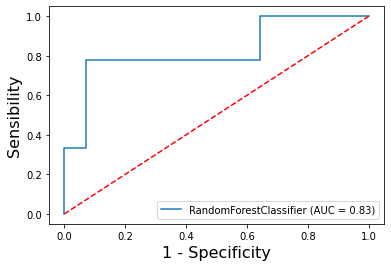

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size = .7)

clf = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)

metrics.plot_roc_curve(clf, X_test, y_test)

plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('1 - Specificity', fontsize=16)
plt.ylabel('Sensibility', fontsize=16)
plt.show() 